In [1]:
import spot
import buddy
from spot.jupyter import display_inline, display
from IPython.core.display import HTML
spot.setup(show_default='.a')

# Example

## Build NBA
NBA formula: $G(a \leftrightarrow b)$

In [2]:
f = spot.formula('G(a <-> b)'); nba = f.translate()

In [3]:
display_inline(nba)

In [4]:
a_varnum, b_varnum = nba.register_ap('a'),nba.register_ap('b')
print("varnum of a", a_varnum)
print("varnum of b", b_varnum)

varnum of a 0
varnum of b 1


## Create NBA Prime

In [5]:
f = spot.formula('G(a <-> b)'); nba_copy = f.translate()
prime_state = nba_copy.new_state()
nba_copy.set_init_state(prime_state)
print('Prime state', prime_state)
display_inline(nba_copy)

Prime state 1


In [6]:
tested_varnum = a_varnum
state = 0

# Clean the prime state
nba_copy.kill_state(prime_state)

# Create the beta condition
beta = buddy.bddfalse
for edge in nba.out(0):
    edge_cond = edge.cond
    beta |= buddy.bdd_restrict(edge_cond, buddy.bdd_nithvar(tested_varnum))
beta &= buddy.bdd_ithvar(tested_varnum)

# Duplicate the edges
for edge in nba.out(0):
    nba_copy.new_edge(prime_state, edge.dst, edge.cond & beta, edge.acc)

display_inline(nba_copy)

## Is contained?

In [7]:
spot.contains(nba, nba_copy)

True

In [8]:
not spot.complement(nba).intersects(nba_copy)

True

# Unates Algorithm

## Find Unate

In [9]:
def find_unates(nba, ltl_formula, var: str, state: int):
    # Create a clone of NBA with a prime state
    nba_prime = spot.formula(ltl_formula).translate()
    prime_state = nba_prime.new_state()
    nba_prime.set_init_state(prime_state)
    
    # Create edges of the prime state
    tested_varnum = nba.register_ap(var)
    beta = buddy.bddfalse
    for edge in nba.out(state):
        edge_cond = edge.cond
        beta |= buddy.bdd_restrict(edge_cond, buddy.bdd_nithvar(tested_varnum))
    beta &= buddy.bdd_ithvar(tested_varnum)

    # Duplicate the edges
    for edge in nba.out(state):
        nba_prime.new_edge(prime_state, edge.dst, edge.cond & beta, edge.acc)
    
    print("NBA Prime (prime state = {}): ".format(prime_state))
    display_inline(nba_prime)
    
    return spot.contains(nba, nba_prime)


Original NBA: 


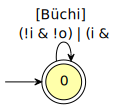

In [10]:
ltl_formula = 'G(o <-> i)'
nba = spot.formula(ltl_formula).translate()

print("Original NBA: ")
display_inline(nba)

NBA Prime (prime state = 1): 


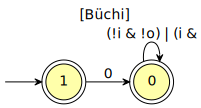

Is variable Unate?  True


In [11]:
is_unate = find_unates(nba, ltl_formula, 'o', 0)
print('Is variable Unate? ', is_unate)

## Handle Unate Variable

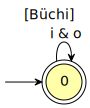

In [12]:
def handle_unate_var(nba, state, var):
    bdd_var = buddy.bdd_ithvar(nba.register_ap(var))
    for edge in nba.out(state):
        edge.cond = edge.cond & bdd_var

if is_unate:
    handle_unate_var(nba, 0, 'o')
display_inline(nba)